# Transfer Learnining

## Load Data

In [12]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [17]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['ants', 'bees']


### Visualize few samples

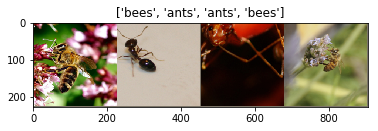

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0)) # Transpose channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())            
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model                


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
                
                

## Fintuning convnet

In [23]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
print(model_ft.fc.out_features)
model_ft.fc = nn.Linear(num_ftrs, 2) # Change fc to new linear layer

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

512
1000
Epoch 0/24
----------
train Loss: 0.5507 Acc: 0.7172
val Loss: 0.1842 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5605 Acc: 0.7623
val Loss: 0.6555 Acc: 0.7451

Epoch 2/24
----------
train Loss: 0.7988 Acc: 0.7295
val Loss: 0.1551 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5741 Acc: 0.7951
val Loss: 0.2649 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5146 Acc: 0.7910
val Loss: 0.2332 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4284 Acc: 0.8525
val Loss: 0.5914 Acc: 0.7582

Epoch 6/24
----------
train Loss: 0.5684 Acc: 0.8074
val Loss: 0.3474 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.4044 Acc: 0.8484
val Loss: 0.2965 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3392 Acc: 0.8607
val Loss: 0.2774 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.2564 Acc: 0.9016
val Loss: 0.2450 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.2895 Acc: 0.8689
val Loss: 0.2589 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3120 Acc: 0.8566
val Loss: 0.2528 Acc: 0

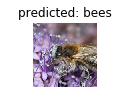

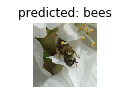

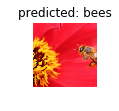

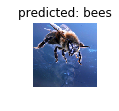

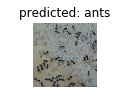

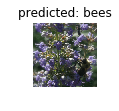

In [24]:
visualize_model(model_ft)

## Fixed feature convnet - only train newly added fully connected layer

In [26]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [27]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7348 Acc: 0.6270
val Loss: 0.2359 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4593 Acc: 0.7910
val Loss: 0.5792 Acc: 0.7451

Epoch 2/24
----------
train Loss: 0.5514 Acc: 0.7500
val Loss: 0.3387 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.4544 Acc: 0.7992
val Loss: 0.3308 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4475 Acc: 0.7869
val Loss: 0.2176 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3987 Acc: 0.8361
val Loss: 0.1760 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5111 Acc: 0.7746
val Loss: 0.3437 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.4283 Acc: 0.7992
val Loss: 0.1789 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2007 Acc: 0.9344
val Loss: 0.1822 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2850 Acc: 0.8811
val Loss: 0.1922 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3159 Acc: 0.8443
val Loss: 0.2037 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3074 Acc: 0.8648
val Loss: 0.1964 Acc: 0.9281

Ep

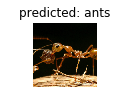

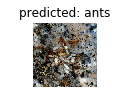

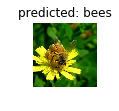

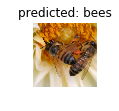

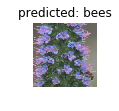

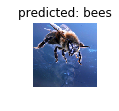

In [31]:
visualize_model(model_conv)
